# The Battle of the Neighborhoods - Chinese Food in Toronto

## Introduction

This is the final project for the IBM Applied Data Science Course. I have chosen to extend the project from week 3, and continue exploring the city of Toronto.

## Problem Statement

The city of Toronto is a very big city with a large variety of cuisines. Many visitors from Asia like to go to Toronto, but they may have problems finding food that they like. For this project, we will make use of data from FourSquare, and identify neighbourhoods that have great Chinese Cuisines. We will recommend the Chinese Restaurants based on their "Likes", "Ratings" and "Tips.

## Data

Our primary sources of data on Toronto will be from the following:

1. Wikipedia: "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
2. Coordinates of Postal Codes: "http://cocl.us/Geospatial_data"

## Approach and Analysis

1. Collect the Toronto City Data from Wikipedia
2. Using FourSquare API to find all venues for each neighborhood.
3. Filter out the Chinese Restaurants
4. Find rating , tips and like count using FourSquare API.
5. Sort the restuarants based on "Likes", "Rating", "Tips"
6. Visualize data using folium library(python)

## Getting the data

In [2]:
import pandas as pd

In [3]:
wiki_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [4]:
tables_df = pd.read_html(wiki_url, header=0)

In [5]:
neigh_df = tables_df[0]

In [6]:
neigh_df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Data Cleaning

#### Remove rows where Borough is "Not assigned"

In [7]:
neigh_df = neigh_df[neigh_df['Borough'] != "Not assigned"]

#### For cells with Borough but Neighbourhood = "Not assigned", Neighbourhood = Borough

In [8]:
neigh_df['Neighbourhood'].replace("Not assigned", neigh_df['Borough'], inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### Combining PostCode with 2 Neighbourhoods

In [9]:
neigh_df = neigh_df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()

In [10]:
neigh_df.shape

(103, 3)

## Retrieving the coordinates of the Postcodes

In [11]:
geo_url = "http://cocl.us/Geospatial_data"
geo_df = pd.read_csv(geo_url)

In [12]:
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
neigh_df.rename(columns={'Postcode':'PostalCode'}, inplace=True)
geo_df.rename(columns={'Postal Code':'PostalCode'}, inplace=True)

In [14]:
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
merged_df = pd.merge(neigh_df, geo_df, on="PostalCode")

In [16]:
merged_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Explore and Visualize Toronto Neighborhood

In [17]:
toronto_df = merged_df[merged_df['Borough'].str.contains("Toronto")]

In [18]:
toronto_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [19]:
import requests
import pandas as pd
import numpy as np

from IPython.display import Image
from IPython.core.display import HTML

from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import os

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


#### We define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [20]:

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#### Established the credentials for access to Foursquare API

In [21]:
CLIENT_ID = 'ZFUB54CXZPSHA52AKJVZVEGOZR2VLALU02IZRA342WWYUKSG' # your Foursquare ID
CLIENT_SECRET = 'H0EKERC2WCFDJXKDUXJB4GU3JYKV3FBP5BLLMYQEFP41GL54' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZFUB54CXZPSHA52AKJVZVEGOZR2VLALU02IZRA342WWYUKSG
CLIENT_SECRET:H0EKERC2WCFDJXKDUXJB4GU3JYKV3FBP5BLLMYQEFP41GL54


#### We define a function to intract with FourSquare API and get top 100 venues within a radius of 500 metres for a given latitude and longitude. 

In [22]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
def get_venues(lat,lng):
    
    #set variables
    radius=500
    LIMIT=100
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [24]:
def get_venue_details(venue_id):
        
       
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

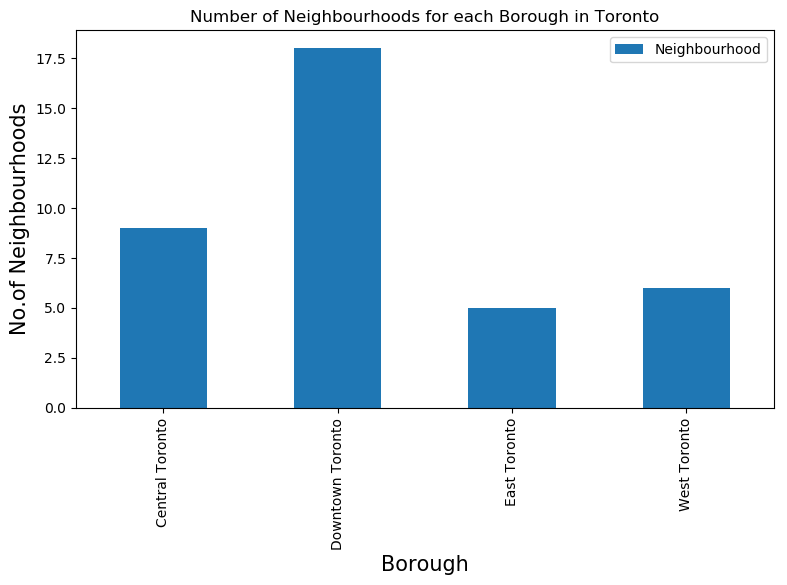

In [25]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighbourhoods for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighbourhoods', fontsize=15)
#giving a bar plot
toronto_df.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [27]:
# prepare neighborhood list that contains Chinese resturants
toronto_df = toronto_df.drop(['PostalCode'], axis=1)
column_names=['Borough', 'Neighbourhood', 'ID','Name']
ch_rest_df = pd.DataFrame(columns=column_names)
count=1
for row in toronto_df.values.tolist():
    Borough, Neighbourhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants = venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(toronto_df),')','Chinese Resturants in '+Neighbourhood+', '+Borough+':'+str(len(chinese_restaurants)))
    for rest_detail in chinese_restaurants.values.tolist():
        id, name , category=rest_detail
        ch_rest_df = ch_rest_df.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 38 ) Chinese Resturants in The Beaches, East Toronto:0
( 2 / 38 ) Chinese Resturants in The Danforth West, Riverdale, East Toronto:0
( 3 / 38 ) Chinese Resturants in The Beaches West, India Bazaar, East Toronto:0
( 4 / 38 ) Chinese Resturants in Studio District, East Toronto:0
( 5 / 38 ) Chinese Resturants in Lawrence Park, Central Toronto:0
( 6 / 38 ) Chinese Resturants in Davisville North, Central Toronto:0
( 7 / 38 ) Chinese Resturants in North Toronto West, Central Toronto:1
( 8 / 38 ) Chinese Resturants in Davisville, Central Toronto:0
( 9 / 38 ) Chinese Resturants in Moore Park, Summerhill East, Central Toronto:0
( 10 / 38 ) Chinese Resturants in Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West, Central Toronto:0
( 11 / 38 ) Chinese Resturants in Rosedale, Downtown Toronto:0
( 12 / 38 ) Chinese Resturants in Cabbagetown, St. James Town, Downtown Toronto:1
( 13 / 38 ) Chinese Resturants in Church and Wellesley, Downtown Toronto:0
( 14 / 38 ) Chinese Resturan

In [28]:
ch_rest_df.shape

(14, 4)

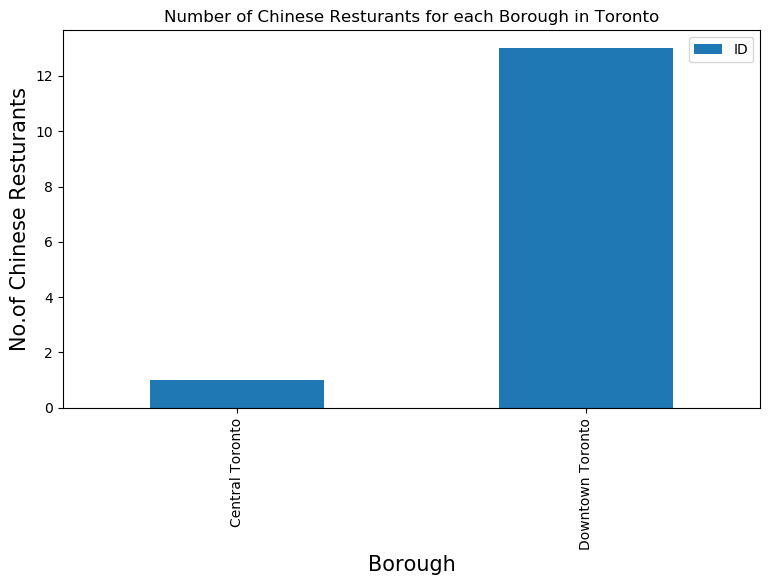

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
ch_rest_df.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

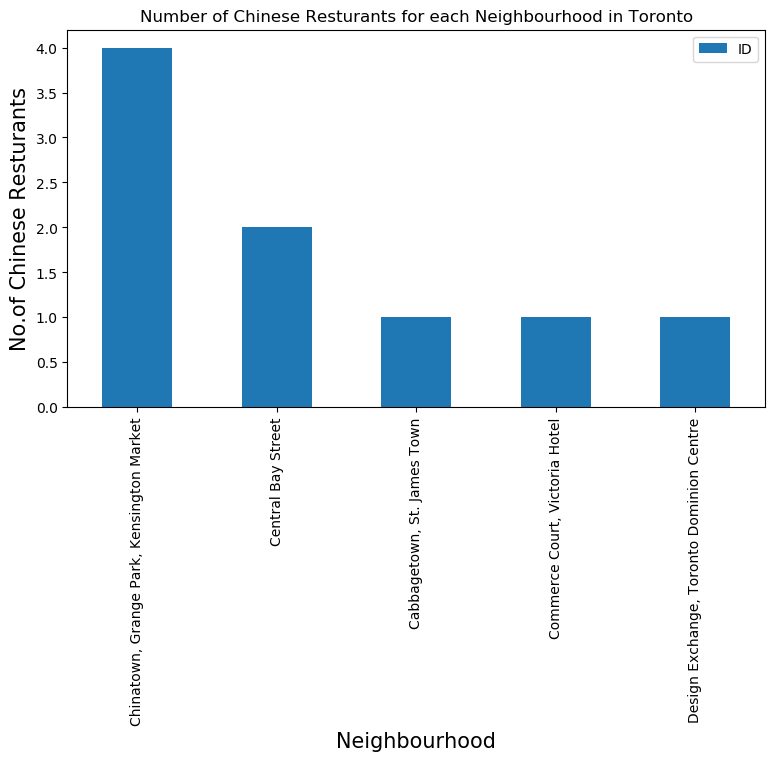

In [30]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Neighbourhood in Toronto')
#On x-axis
plt.xlabel('Neighbourhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
ch_rest_df.groupby('Neighbourhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [31]:
ch_rest_df[ch_rest_df['Neighbourhood'] == "Chinatown, Grange Park, Kensington Market"]

,Borough,Neighbourhood,ID,Name
9,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",4ae29812f964a520288f21e3,Swatow Restaurant 汕頭小食家
10,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",4fd3ea3ee4b0191b9c2b1aff,Rosewood Chinese Cuisine
11,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",4b074bb1f964a52077fb22e3,New Sky Restaurant 小沙田食家
12,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",4adb5472f964a520fc2521e3,Asian Legend 味香村


#### We will get the ranking of each restaurant for further analysis

In [32]:
column_names=['Borough', 'Neighbourhood', 'ID','Name','Likes','Rating','Tips']
ch_rest_stats_df = pd.DataFrame(columns=column_names)
count=1


for row in ch_rest_df.values.tolist():
    Borough,Neighbourhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(ch_rest_df),')','processed')
    ch_rest_stats_df = ch_rest_stats_df.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  4aec79e5f964a5209fc721e3  C'est Bon      7     7.3     6
( 1 / 14 ) processed
                         ID           Name  Likes  Rating  Tips
0  4bca992068f976b017d35f83  China Gourmet      4     5.9     6
( 2 / 14 ) processed
                         ID                    Name  Likes  Rating  Tips
0  58e91d60e0adac258fcea481  GB Hand-Pulled Noodles     34     7.8     9
( 3 / 14 ) processed
                         ID                    Name  Likes  Rating  Tips
0  58e91d60e0adac258fcea481  GB Hand-Pulled Noodles     34     7.8     9
( 4 / 14 ) processed
                         ID                          Name  Likes  Rating  Tips
0  52a7ae41498eed3af4d0a3fa  Yueh Tung Chinese Restaurant     33     7.8    10
( 5 / 14 ) processed
                         ID                Name  Likes  Rating  Tips
0  4ae33054f964a520759121e3  Pearl Harbourfront    116     8.1    34
( 6 / 14 ) processed
                         ID           

#### We will now save the data into a csv file so that we do not make repeated calls to Foursquare.

In [33]:
ch_rest_stats_df.to_csv('ch_rest_stats_df.csv', index=False)

In [34]:
ch_rest_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 7 columns):
Borough          14 non-null object
Neighbourhood    14 non-null object
ID               14 non-null object
Name             14 non-null object
Likes            14 non-null object
Rating           14 non-null float64
Tips             14 non-null object
dtypes: float64(1), object(6)
memory usage: 864.0+ bytes


In [35]:
ch_rest_stats_csv=pd.read_csv('ch_rest_stats_df.csv')

In [36]:
ch_rest_stats_csv.head()

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,Central Toronto,North Toronto West,4aec79e5f964a5209fc721e3,C'est Bon,7,7.3,6
1,Downtown Toronto,"Cabbagetown, St. James Town",4bca992068f976b017d35f83,China Gourmet,4,5.9,6
2,Downtown Toronto,"Ryerson, Garden District",58e91d60e0adac258fcea481,GB Hand-Pulled Noodles,34,7.8,9
3,Downtown Toronto,Central Bay Street,58e91d60e0adac258fcea481,GB Hand-Pulled Noodles,34,7.8,9
4,Downtown Toronto,Central Bay Street,52a7ae41498eed3af4d0a3fa,Yueh Tung Chinese Restaurant,33,7.8,10


#### We will convert "Tips" and "Likes" into floats for analysis

In [37]:
ch_rest_stats_df['Likes'] = ch_rest_stats_df['Likes'].astype('float64')
ch_rest_stats_df['Tips'] = ch_rest_stats_df['Tips'].astype('float64')

In [38]:
ch_rest_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 7 columns):
Borough          14 non-null object
Neighbourhood    14 non-null object
ID               14 non-null object
Name             14 non-null object
Likes            14 non-null float64
Rating           14 non-null float64
Tips             14 non-null float64
dtypes: float64(3), object(4)
memory usage: 864.0+ bytes


In [39]:
ch_rest_stats_df

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,Central Toronto,North Toronto West,4aec79e5f964a5209fc721e3,C'est Bon,7.0,7.3,6.0
1,Downtown Toronto,"Cabbagetown, St. James Town",4bca992068f976b017d35f83,China Gourmet,4.0,5.9,6.0
2,Downtown Toronto,"Ryerson, Garden District",58e91d60e0adac258fcea481,GB Hand-Pulled Noodles,34.0,7.8,9.0
3,Downtown Toronto,Central Bay Street,58e91d60e0adac258fcea481,GB Hand-Pulled Noodles,34.0,7.8,9.0
4,Downtown Toronto,Central Bay Street,52a7ae41498eed3af4d0a3fa,Yueh Tung Chinese Restaurant,33.0,7.8,10.0
5,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",4ae33054f964a520759121e3,Pearl Harbourfront,116.0,8.1,34.0
6,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",4d7a6212e8b7a1cdb919971f,Szechuan Express,12.0,7.2,5.0
7,Downtown Toronto,"Commerce Court, Victoria Hotel",4d7a6212e8b7a1cdb919971f,Szechuan Express,12.0,7.2,5.0
8,Downtown Toronto,"Harbord, University of Toronto",4b340703f964a5200d2425e3,River Tai Restaurant,5.0,6.7,5.0
9,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",4ae29812f964a520288f21e3,Swatow Restaurant 汕頭小食家,86.0,7.7,53.0


In [40]:
ch_rest_stats_df = pd.merge(ch_rest_stats_df, toronto_df, on=['Borough','Neighbourhood'])

In [41]:
ch_rest_stats_df.head()

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips,Latitude,Longitude
0,Central Toronto,North Toronto West,4aec79e5f964a5209fc721e3,C'est Bon,7.0,7.3,6.0,43.715383,-79.405678
1,Downtown Toronto,"Cabbagetown, St. James Town",4bca992068f976b017d35f83,China Gourmet,4.0,5.9,6.0,43.667967,-79.367675
2,Downtown Toronto,"Ryerson, Garden District",58e91d60e0adac258fcea481,GB Hand-Pulled Noodles,34.0,7.8,9.0,43.657162,-79.378937
3,Downtown Toronto,Central Bay Street,58e91d60e0adac258fcea481,GB Hand-Pulled Noodles,34.0,7.8,9.0,43.657952,-79.387383
4,Downtown Toronto,Central Bay Street,52a7ae41498eed3af4d0a3fa,Yueh Tung Chinese Restaurant,33.0,7.8,10.0,43.657952,-79.387383


#### Chinese Restaurants with above average number of Likes

In [42]:
ch_likes_df = ch_rest_stats_df[ch_rest_stats_df['Likes'] > ch_rest_stats_df['Likes'].mean()].sort_values(['Likes'], ascending=False)

In [43]:
ch_likes_df

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips,Latitude,Longitude
5,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",4ae33054f964a520759121e3,Pearl Harbourfront,116.0,8.1,34.0,43.640816,-79.381752
12,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",4adb5472f964a520fc2521e3,Asian Legend 味香村,105.0,7.7,44.0,43.653206,-79.400049
9,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",4ae29812f964a520288f21e3,Swatow Restaurant 汕頭小食家,86.0,7.7,53.0,43.653206,-79.400049
10,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",4fd3ea3ee4b0191b9c2b1aff,Rosewood Chinese Cuisine,53.0,7.7,26.0,43.653206,-79.400049


#### Present the information on a map

In [44]:
# create map and display it
toronto_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)

In [45]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ch_likes_df[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [46]:
ch_likes_df['Label']=ch_likes_df['Neighbourhood']+', '+ch_likes_df['Borough']+'('+ch_likes_df['Likes'].map(str)+')'

In [48]:

# add pop-up text to each marker on the map
for lat, lng, label in ch_likes_df[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(toronto_map)

toronto_map.add_child(incidents)

#### Chinese Restaurants with above average Ratings

In [49]:
ch_rating_df = ch_rest_stats_df[ch_rest_stats_df['Rating'] > ch_rest_stats_df['Rating'].mean()].sort_values(['Rating'], ascending=False)

In [50]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ch_rating_df[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [51]:
ch_rating_df['Label']=ch_rating_df['Neighbourhood']+', '+ch_rating_df['Borough']+'('+ch_rating_df['Rating'].map(str)+')'

In [53]:

# add pop-up text to each marker on the map
for lat, lng, label in ch_rating_df[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(toronto_map)

toronto_map.add_child(incidents)

#### Chinese Restarants with above average number of Tips

In [54]:
ch_tips_df = ch_rest_stats_df[ch_rest_stats_df['Tips'] > ch_rest_stats_df['Tips'].mean()].sort_values(['Tips'], ascending=False)

In [55]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ch_tips_df[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [57]:
ch_tips_df['Label']=ch_tips_df['Neighbourhood']+', '+ch_tips_df['Borough']+'('+ch_tips_df['Tips'].map(str)+')'

In [58]:
# add pop-up text to each marker on the map
for lat, lng, label in ch_tips_df[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(toronto_map)

toronto_map.add_child(incidents)

## Conclusions

1. Most of the Chinese Restaurants are located in Downtown Toronto
2. Specifically, Chinatown has the most numbers of Chinese Restaurants
3. Based on the data provided from Foursquares, we are able to pinpoint the exact locations of the restaurants that have the most "Likes", "Tips" or with the highest "Ratings"
4. We are then able to plot on a map, and for easy reference for any visitors to the city.
5. This project can be easily extended to other cities, or to identify other cuisines or landmarks.